In [246]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import torch
from torch import nn

import os
import sys
import glob
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
SEED = 52
torch.manual_seed(SEED)

In [248]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [249]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synthetic_exp_2d_20181206-160527.pkl
../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181206-163850.pkl


In [250]:
# SET THESE PARAMETERS
process_dim = 2
print("Process dimension: {}".format(process_dim))
chosen_data_file = SYNTH_DATA_FILES[2]
print("Data file: {}".format(chosen_data_file))

Process dimension: 2
Data file: ../data/simulated/hawkes_synthetic_exp_2d_20181206-163850.pkl


In [252]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)
print(seq_times.shape)

Loading 2-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	[0.2 0.2]
alpha	[[0.1  0.15]
 [0.01 0.01]]
decay	8
tmax	3600
torch.Size([2000, 1838])


# Neural network

In [207]:
from utils import one_hot_embedding

In [214]:
seq_types

tensor([[2, 0, 0,  ..., 2, 2, 2],
        [2, 0, 0,  ..., 2, 2, 2],
        [2, 0, 1,  ..., 2, 2, 2],
        ...,
        [2, 0, 1,  ..., 2, 2, 2],
        [2, 1, 1,  ..., 2, 2, 2],
        [2, 0, 1,  ..., 2, 2, 2]])

In [215]:
seq_types.shape

torch.Size([2000, 1838])

In [221]:
doh = one_hot_embedding(seq_types[:1, :3], 3)

In [222]:
doh

tensor([[[0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.]]])

In [241]:
dooh = doh[:, :, :2]

In [242]:
dooh

tensor([[[0., 0.],
         [1., 0.],
         [1., 0.]]])

In [243]:
x = torch.Tensor([[
    [1, 1],
    [2, 3],
    [4, 1.5]
]])
x.log_()

tensor([[[0.0000, 0.0000],
         [0.6931, 1.0986],
         [1.3863, 0.4055]]])

In [245]:
torch.sum(dooh*x, dim=2)

tensor([[0.0000, 0.6931, 1.3863]])

In [11]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= f(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [185]:
from train_functions import train_decayrnn, plot_loss

In [186]:
# define training data
train_size = 3000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 3000
Train event times shape torch.Size([3000, 158])
Train event types shape torch.Size([3000, 158])
Train seq lengths shape torch.Size([3000])


In [187]:
process_dim = 1
hidden_size = 32
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.021)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

loss_hist, train_hist = train_decayrnn(
    model, optimizer, train_times_tensor,
    train_seq_types, train_seq_lengths, tmax,
    BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 20
Train size: 3000


epoch 1: train loss 75.3583


epoch 2: train loss 73.1276


epoch 3: train loss 73.0070


epoch 4: train loss 72.9798


epoch 5: train loss 72.9210


epoch 6: train loss 72.8862


epoch 7: train loss 72.8575


epoch 8: train loss 72.8704


epoch 9: train loss 72.8076


epoch 10: train loss 72.8460


epoch 11: train loss 72.7967


epoch 12: train loss 72.7633


epoch 13: train loss 72.7773


epoch 14: train loss 72.7504


epoch 15: train loss 72.7343


epoch 16: train loss 72.7345


epoch 17: train loss 72.7300


epoch 18: train loss 72.7261


epoch 19: train loss 72.6996


epoch 20: train loss 72.6911


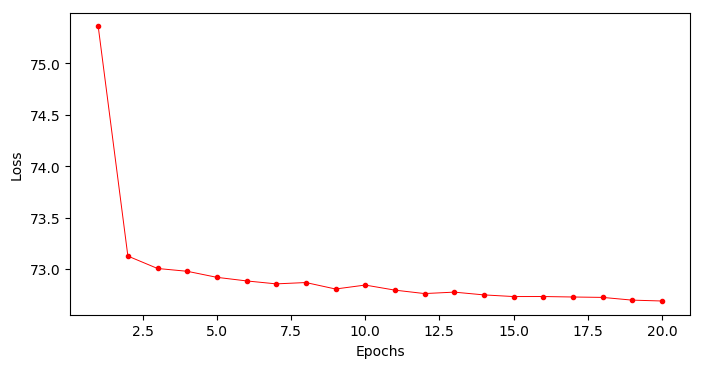

In [188]:
_ = plot_loss(EPOCHS, loss_hist)

In [189]:
import datetime
# Generate save params to record the model
# Model file dump
SAVED_MODELS_PATH = '../saved_models'
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

In [190]:
# This cell resets the timestamp !!
date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)

Now we save the model down to a file, and record the data files on which it was trained.

In [193]:
import json

filename_base = "{}-{}_hidden{}-{}".format(
    model.__class__.__name__, extra_tag,
    hidden_size, now_timestamp)
filename_model_save = filename_base + ".pth"
model_filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Model save file path: {}".format(model_filepath))

Model save file path: ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


In [194]:
file_correspondance = {
    "model_path": model_filepath,
    "data_path": chosen_data_file
}
print(file_correspondance)

{'model_path': '../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth', 'data_path': '../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl'}


In [195]:
with open(os.path.join(SAVED_MODELS_PATH, "train_data_correspondance.jsonl"), "a") as f:
    json.dump(file_correspondance, f)

print("Saving model state dict to {}".format(model_filepath))
torch.save(model.state_dict(), model_filepath)

Saving model state dict to ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


# Model evaluation

In [253]:
tmax = 3600

Let us load up a model

In [254]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

In [257]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
for p in MODEL_FILES:
    print(p)

../saved_models/HawkesLSTM-1d_hidden64-20181206-235311.pth
../saved_models/HawkesDecayRNN-2d_hidden128-20181207-182240.pth
../saved_models/HawkesDecayRNN-1d_hidden64-20181206-234848.pth


In [258]:
load_filename = MODEL_FILES[1]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

chosen file: ../saved_models/HawkesDecayRNN-2d_hidden128-20181207-182240.pth
20181207-182240


In [259]:
process_dim = 2
hidden_size = 128
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 128


## Sequence generation

### Untrained model, random weights

In [261]:
print("Real end time: {}".format(tmax))

Real end time: 3600


In [262]:
raw_model = HawkesDecayRNN(2, hidden_size)
generator_base = HawkesRNNGen(raw_model)

Process model dim:	2	Hidden units:	128


no. of events: 12
0: type 0
1: type 1


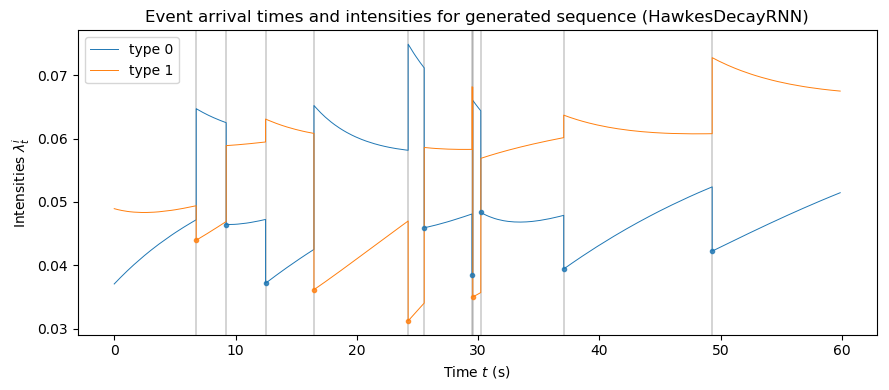

In [263]:
tmax_simu = 60
generator_base.generate_sequence(tmax_simu, record_intensity=True)

fig = generator_base.plot_events_and_intensity(debug=False)
fig.tight_layout()

In [264]:
generator_base.generate_sequence(tmax)

In [265]:
print(len(generator_base.event_times))
print(len(generator_base._plot_times))

373
1499


### On trained model

In [266]:
RESULT_BASEDIR = "../results"

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesDecayRNN


In [267]:
generator = HawkesRNNGen(model, record_intensity=False)

Process model dim:	2	Hidden units:	128


no. of events: 28
0: type 0
1: type 1


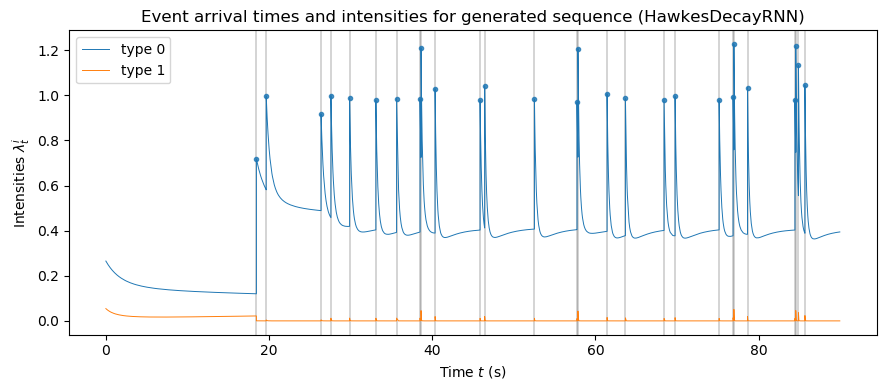

In [271]:
tmax_simu = 90
generator.generate_sequence(tmax_simu, record_intensity=True)
fig_intensity_stream = generator.plot_events_and_intensity()

In [94]:
fig_intensity_stream.savefig("../results/intensity_{}_{}d_hidden{}_{}.pdf".format(
    MODEL_NAME, process_dim, hidden_size, load_file_timestamp))

## Sequence length distribution

In [112]:
from utils import evaluation

In [102]:
generator.generate_sequence(tmax)

In [103]:
print(len(generator.event_times))
print(len(generator._plot_times))

699
1943


In [113]:
gen_seq_lengths, gen_seq_types_lengths = evaluation.generate_multiple_sequences(generator, tmax)

Mean generated sequence length: 696.95
Generated sequence length std. dev: 26.742615803245574


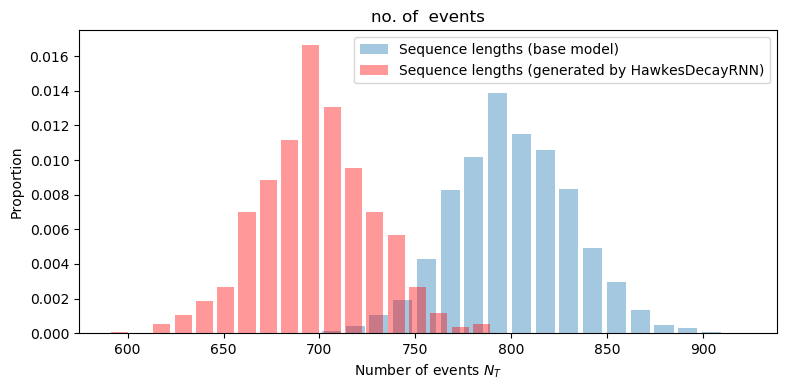

In [109]:
if process_dim > 1:
    num_plots = process_dim + 1
else:
    num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(8,4+(num_plots-1)*3), dpi=100)
ax0 = axes[0] if num_plots > 1 else axes
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}
gen_label = "Sequence lengths (generated by {:})".format(MODEL_NAME)
_ = ax0.hist(seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label=gen_label,
            color='red', **hist_opts)
ax0.legend()
if num_plots > 1:
    ax0.set_title('no. of events (all types, including starter type)')
else:
    ax0.set_title('no. of  events')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
if num_plots > 1:
    axt = axes[1:]
    for i, ax in enumerate(axt):
        # get the sequence lengths for the event types
        typ_seq_lengths = (seq_types == i).sum(dim=1)
        gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
        ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
                label="Sequence lengths (base model)",
                **hist_opts)
        ax.hist(gen_typ_seq_lengths,
                bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
                label=gen_label,
                color='red', **hist_opts)
        ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
        ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [110]:
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "length_distrib"
distrib_plot_filepath = "{:}/{:}_{:}-{}-hidden_{}-{}.pdf".format(
    RESULT_BASEDIR, model_perf_indicator, MODEL_NAME,
    extra_tag, model.hidden_size, load_file_timestamp)
fig.savefig(distrib_plot_filepath)

## Event prediction

The $L_2$-wise best estimator for the next event occurrence time is given by

$$
\begin{aligned}
    \hat{t}_i &= \mathbb{E}[t_i\mid\mathcal F_{t_{i-1}}] \\
    &= t_{i-1} + \int_0^\infty u p_i(u)\, du
\end{aligned}
$$

In [167]:
import tqdm
from models.decayrnn import read_predict

In [168]:
dataset_size = seq_times.shape[0]
print(dataset_size)

train_size = 1600
test_size = 400

2000


1261


((tensor(2.1523), tensor(3.2332), tensor(1.1683), tensor(1), tensor(0)),
 <Figure size 1000x400 with 2 Axes>)

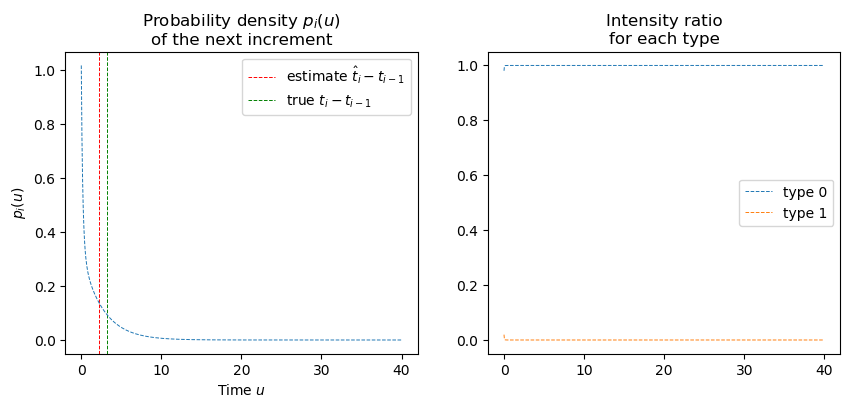

In [201]:
my_index = torch.randint(0, dataset_size, (1,)).int().item()
print(my_index)

_seq_data = (seq_times[my_index],
             seq_types[my_index],
             seq_lengths[my_index])

read_predict(model, *_seq_data, plot=True)

In [31]:
test_size = 2000

In [31]:
estimates = []
real_incrs = []
errors = []
index_range_ = tqdm.tnrange(4000,4000+test_size)

for index_ in index_range_:
    _seq_data = (seq_times[index_],
                 seq_types[index_],
                 seq_lengths[index_])

    est, real_dt, err, _, _ = read_predict(model, *_seq_data)
    estimates.append(est)
    real_incrs.append(real_dt)
    errors.append(err)

$$
    \mathrm{RMSE} = \sqrt{\mathbb E[(\hat{t}_i - t_i)^2]}
$$

In [133]:
import json

In [131]:
avg_rmse = np.sqrt(np.mean(errors), dtype=np.float64)
print(avg_rmse)

mse_var = np.var(errors, dtype=np.float64)
print(mse_var)

delta_meth_stderr = 1/test_size*mse_var/(4*avg_rmse)
print(delta_meth_stderr)

In [131]:
predict_data = {
    "model_name": MODEL_NAME,
    "process_dim": process_dim,
    "hidden_size": hidden_size,
    "data_file": chosen_data_file,
    "avg_rmse": avg_rmse,
    "var_mse": mse_var,
    "std_rmse": delta_meth_stderr
}

predict_data

In [114]:
predict_res_file = "predict_results.json"

In [115]:
predict_data.keys()

dict_keys(['model_name', 'process_dim', 'hidden_size', 'data_file', 'avg_rmse', 'var_mse', 'std_rmse'])

In [132]:
with open(predict_res_file, "a", encoding='utf-8', newline='\n') as fp:
    json.dump(predict_data, fp)